In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import joblib
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Modèles et métriques
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class NutriscorePredictor:
    '''
    Prédicteur de nutriscore SANS DATA LEAKAGE
    '''

    def __init__(self, sample_size=None, random_state=42, model_dir='nutriscore_models'):
        self.sample_size = sample_size
        self.random_state = random_state
        self.model = None
        self.scaler = None
        self.feature_selector = None
        self.feature_names = None
        self.target_encoders = {}
        self.model_dir = model_dir
        self.validation_curves = {}

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

    def load_and_clean_data(self, filepath):
        '''Chargement avec validation de qualité'''
        print("📂 Chargement et validation des données...")
        df = pd.read_csv(filepath)
        print(f"Dataset original: {df.shape}")

        # ⭐ CORRECTION DATA LEAKAGE : Supprimer TOUTES les colonnes dérivées du nutriscore
        leakage_cols = [
            'Unnamed: 0', 'generic_name', 'quantity', 'origins_en', 'traces_en',
            'additives_en', 'vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g',
            'calcium_100g', 'iron_100g', 'trans-fat_100g', 'cholesterol_100g',
            'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'ecoscore_score',
            'ecoscore_grade', 'product_name',
            # ⚠️ NOUVELLES SUPPRESSIONS ANTI-LEAKAGE
            'nutrition-score-fr_100g',  # Score nutriscore français → LEAKAGE !
            'nutrition-score-uk_100g',  # Score nutriscore UK → LEAKAGE !
            'nutriscore_grade',          # Grade nutriscore → LEAKAGE !
            'nova_group',                # Parfois corrélé au nutriscore
        ]

        print(f"🚨 Suppression features à risque de leakage: {[col for col in leakage_cols if col in df.columns]}")
        df = df.drop(columns=leakage_cols, errors='ignore')

        # Filtrage qualité PLUS STRICT
        initial_size = len(df)

        # 1. Supprimer lignes sans nutriscore
        df = df.dropna(subset=['nutriscore_score'])

        # 2. Filtrer valeurs aberrantes nutriscore
        df = df[(df['nutriscore_score'] >= -15) & (df['nutriscore_score'] <= 40)]

        # 3. Filtrer valeurs nutritionnelles aberrantes
        for col in ['energy-kcal_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g']:
            if col in df.columns:
                Q1 = df[col].quantile(0.01)
                Q99 = df[col].quantile(0.99)
                df = df[(df[col] >= Q1) & (df[col] <= Q99)]

        # 4. Supprimer doublons potentiels
        df = df.drop_duplicates(subset=['energy-kcal_100g', 'fat_100g', 'carbohydrates_100g', 
                                       'sugars_100g', 'proteins_100g'], keep='first')

        print(f"Après nettoyage qualité: {len(df)} (supprimé {initial_size - len(df)} lignes)")

        # Échantillonnage STRATIFIÉ pour préserver la distribution
        if self.sample_size and len(df) > self.sample_size:
            # Stratification par quartiles de nutriscore
            df['nutriscore_quartile'] = pd.qcut(df['nutriscore_score'], q=4, labels=False)
            df_sampled = df.groupby('nutriscore_quartile').apply(
                lambda x: x.sample(n=min(len(x), self.sample_size//4), random_state=self.random_state)
            ).reset_index(drop=True)
            df = df_sampled.drop('nutriscore_quartile', axis=1)
            print(f"Échantillonnage stratifié: {len(df)}")

        return df

    def feature_engineering_robust(self, df):
        '''Feature engineering avec protection contre l'overfitting ET leakage'''
        print("⚙️  Feature engineering robuste SANS LEAKAGE...")
        df = df.copy()

        # ⭐ VÉRIFICATION ANTI-LEAKAGE
        suspicious_cols = [col for col in df.columns if any(keyword in col.lower() 
                          for keyword in ['nutri', 'score', 'grade', 'nova'])]
        if suspicious_cols:
            print(f"⚠️  Colonnes suspectes détectées: {suspicious_cols}")
            # On garde seulement nutriscore_score (notre target)
            for col in suspicious_cols:
                if col != 'nutriscore_score':
                    print(f"   🗑️  Suppression: {col}")
                    df = df.drop(columns=[col], errors='ignore')

        # ==========================================
        # 1. IMPUTATION CONSERVATIVE
        # ==========================================

        # Fibres - valeur médiane globale (plus conservatrice que par groupe)
        if 'fiber_100g' in df.columns:
            median_fiber = df['fiber_100g'].median()
            df['fiber_missing'] = df['fiber_100g'].isna().astype(int)
            df['fiber_100g'] = df['fiber_100g'].fillna(median_fiber)

        # Fruits/légumes - 0 par défaut (conservateur)
        fruit_col = 'fruits-vegetables-nuts-estimate-from-ingredients_100g'
        if fruit_col in df.columns:
            df['fruits_missing'] = df[fruit_col].isna().astype(int)
            df[fruit_col] = df[fruit_col].fillna(0)

        # Additifs - 0 par défaut
        if 'additives_n' in df.columns:
            df['additives_missing'] = df['additives_n'].isna().astype(int)
            df['additives_n'] = df['additives_n'].fillna(0)

        # ==========================================
        # 2. TARGET ENCODING AVEC RÉGULARISATION
        # ==========================================

        categorical_cols = ['brands', 'categories_en', 'countries_en', 
                          'food_groups_en', 'main_category_en']

        categorical_cols_to_drop = []  # Pour supprimer après encoding

        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].fillna('unknown')

                # Réduction TRÈS AGGRESSIVE (top 10 seulement)
                value_counts = df[col].value_counts()
                min_count = max(100, len(df) // 500)  # Au moins 100 ou 0.2% du dataset
                valid_categories = value_counts[value_counts >= min_count].head(10).index
                df[col] = df[col].where(df[col].isin(valid_categories), 'other')

                # TARGET ENCODING RÉGULARISÉ (avec smoothing)
                global_mean = df['nutriscore_score'].mean()

                # Smoothing factor (plus la catégorie a peu d'exemples, plus on tend vers la moyenne globale)
                category_stats = df.groupby(col)['nutriscore_score'].agg(['mean', 'count'])
                smoothing_factor = 10  # Hyperparamètre de régularisation

                regularized_means = {}
                for category in category_stats.index:
                    cat_mean = category_stats.loc[category, 'mean']
                    cat_count = category_stats.loc[category, 'count']

                    # Shrinkage vers la moyenne globale
                    regularized_mean = (cat_count * cat_mean + smoothing_factor * global_mean) / (cat_count + smoothing_factor)
                    regularized_means[category] = regularized_mean

                # Sauvegarder pour prédictions futures
                self.target_encoders[f'{col}_target'] = regularized_means
                self.target_encoders[f'{col}_global_mean'] = global_mean

                df[f'{col}_target_enc'] = df[col].map(regularized_means).fillna(global_mean)

                # Fréquence encoding (moins risqué d'overfitting)
                freq_map = df[col].value_counts() / len(df)
                self.target_encoders[f'{col}_freq'] = freq_map.to_dict()
                df[f'{col}_freq'] = df[col].map(freq_map).fillna(0)

                # Marquer pour suppression
                categorical_cols_to_drop.append(col)

        # Supprimer les colonnes catégorielles originales
        print(f"🗑️  Suppression des colonnes catégorielles originales: {categorical_cols_to_drop}")
        df = df.drop(columns=categorical_cols_to_drop, errors='ignore')

        # ==========================================
        # 3. FEATURES DÉRIVÉES ROBUSTES (sans leakage)
        # ==========================================

        # Features basées sur formule nutriscore officielle (mais pas le score lui-même)
        if 'energy-kcal_100g' in df.columns:
            df['energy_density'] = np.clip(df['energy-kcal_100g'] / 100, 0, 10)

        # Ratios avec clipping pour éviter valeurs extrêmes
        if 'sugars_100g' in df.columns and 'carbohydrates_100g' in df.columns:
            df['sugar_carb_ratio'] = np.clip(
                df['sugars_100g'] / (df['carbohydrates_100g'] + 1e-6), 0, 2
            )

        if 'saturated-fat_100g' in df.columns and 'fat_100g' in df.columns:
            df['sat_fat_total_ratio'] = np.clip(
                df['saturated-fat_100g'] / (df['fat_100g'] + 1e-6), 0, 2
            )

        # Features composites simplifiées
        fiber_val = df.get('fiber_100g', 0)
        protein_val = df.get('proteins_100g', 0) 
        fruit_val = df.get(fruit_col, 0)

        df['positive_nutrients'] = np.clip(fiber_val + protein_val + fruit_val, 0, 100)

        if all(col in df.columns for col in ['energy-kcal_100g', 'saturated-fat_100g', 'sugars_100g', 'sodium_100g']):
            df['negative_nutrients'] = np.clip(
                df['energy-kcal_100g']/100 + df['saturated-fat_100g'] + 
                df['sugars_100g'] + df['sodium_100g']*1000, 0, 200
            )

        # ⭐ VÉRIIFICATION FINALE : S'assurer que toutes les colonnes sont numériques
        print("🔍 Vérification finale anti-leakage...")
        non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
        if 'nutriscore_score' in non_numeric_cols:
            non_numeric_cols.remove('nutriscore_score')

        if non_numeric_cols:
            print(f"⚠️  Colonnes non-numériques détectées: {non_numeric_cols}")
            # Supprimer ou encoder ces colonnes
            for col in non_numeric_cols:
                if col != 'nutriscore_score':  # Préserver la target
                    print(f"   Suppression de {col}")
                    df = df.drop(columns=[col])

        print(f"✅ Dataset final SANS LEAKAGE: {df.shape} - Toutes colonnes numériques")
        print(f"📋 Colonnes finales: {list(df.columns)}")

        return df

    def feature_selection(self, X, y):
        '''Sélection de features pour réduire l'overfitting'''
        print("🎯 Sélection de features anti-overfitting...")

        # Vérification finale avant sélection
        print(f"Features avant sélection: {X.shape[1]}")
        print(f"Types de données: {X.dtypes.value_counts().to_dict()}")

        # 1. Supprimer features à faible variance
        from sklearn.feature_selection import VarianceThreshold
        variance_selector = VarianceThreshold(threshold=0.01)
        X_var = variance_selector.fit_transform(X)
        selected_features = X.columns[variance_selector.get_support()]

        print(f"Après suppression faible variance: {len(selected_features)} features")

        # 2. Sélection univariée (top K)
        max_features = min(20, len(selected_features))  # Maximum 20 features
        k_best = SelectKBest(score_func=f_regression, k=max_features)
        X_selected = k_best.fit_transform(X[selected_features], y)

        final_features = selected_features[k_best.get_support()]

        print(f"Features finales sélectionnées: {len(final_features)}")
        print(f"Features: {list(final_features)}")

        self.feature_selector = {
            'variance_selector': variance_selector,
            'k_best': k_best,
            'selected_features': selected_features,
            'final_features': final_features
        }

        return X[final_features], final_features

    def create_train_val_test_split(self, X, y):
        '''Split robuste train/validation/test'''
        print("📊 Création des splits train/validation/test...")

        # Split initial train (60%) / test (40%)
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state, stratify=None
        )

        # Split train (48%) / validation (32%) du dataset total
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.4, random_state=self.random_state
        )

        print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
        print(f"Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
        print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def train_with_overfitting_protection(self, X_train, X_val, X_test, y_train, y_val, y_test):
        '''Entraînement avec protection contre l'overfitting'''
        print("\n🛡️  Entraînement RÉALISTE (sans leakage)...")

        # Standardisation
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)
        X_test_scaled = self.scaler.transform(X_test)

        # ==========================================
        # 1. MODÈLES AVEC RÉGULARISATION FORTE
        # ==========================================

        models_configs = {
            'Ridge_strong': {
                'model': Ridge(),
                'param_grid': {
                    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]  # Régularisation forte
                },
                'use_scaled': True
            },

            'ElasticNet': {
                'model': ElasticNet(random_state=self.random_state, max_iter=10000),
                'param_grid': {
                    'alpha': [0.1, 1.0, 10.0],
                    'l1_ratio': [0.1, 0.5, 0.9]  # Mix L1/L2
                },
                'use_scaled': True
            },

            'RandomForest_conservative': {
                'model': RandomForestRegressor(random_state=self.random_state, n_jobs=-1),
                'param_grid': {
                    'n_estimators': [50, 100],
                    'max_depth': [5, 10, 15],  # Profondeur limitée
                    'min_samples_split': [20, 50],  # Évite splits sur peu d'exemples
                    'min_samples_leaf': [10, 20],   # Feuilles avec minimum d'exemples
                    'max_features': ['sqrt', 0.5]   # Limite les features par arbre
                },
                'use_scaled': False
            }
        }

        results = {}

        for name, config in models_configs.items():
            print(f"\n🔍 Optimisation {name} avec GridSearchCV...")

            # Données appropriées
            if config['use_scaled']:
                X_tr, X_v, X_te = X_train_scaled, X_val_scaled, X_test_scaled
            else:
                X_tr, X_v, X_te = X_train, X_val, X_test

            # GridSearch avec validation croisée STRATIFIÉE
            grid_search = GridSearchCV(
                estimator=config['model'],
                param_grid=config['param_grid'],
                cv=5,  # 5-fold CV
                scoring='r2',
                n_jobs=-1,
                verbose=0
            )

            start_time = time.time()
            grid_search.fit(X_tr, y_train)
            train_time = time.time() - start_time

            best_model = grid_search.best_estimator_

            # Évaluation sur validation
            y_val_pred = best_model.predict(X_v)
            val_r2 = r2_score(y_val, y_val_pred)
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

            # Évaluation sur test
            y_test_pred = best_model.predict(X_te)
            test_r2 = r2_score(y_test, y_test_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

            # Détection d'overfitting
            train_r2 = grid_search.best_score_
            overfitting_score = train_r2 - val_r2  # Plus c'est élevé, plus il y a overfitting

            results[name] = {
                'model': best_model,
                'best_params': grid_search.best_params_,
                'train_r2': train_r2,
                'val_r2': val_r2,
                'test_r2': test_r2,
                'val_rmse': val_rmse,
                'test_rmse': test_rmse,
                'overfitting_score': overfitting_score,
                'train_time': train_time,
                'use_scaled': config['use_scaled'],
                'y_test_pred': y_test_pred,
                'y_test_true': y_test
            }

            print(f"   Meilleurs params: {grid_search.best_params_}")
            print(f"   R² train (CV): {train_r2:.4f}")
            print(f"   R² validation: {val_r2:.4f}")
            print(f"   R² test: {test_r2:.4f}")
            print(f"   Overfitting: {overfitting_score:.4f} ({'⚠️ Élevé' if overfitting_score > 0.1 else '✅ OK'})")

        return results

    def plot_overfitting_analysis(self, results):
        '''Analyse visuelle de l'overfitting'''
        print("\n📊 Analyse de l'overfitting RÉALISTE...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Analyse Anti-Overfitting (SANS DATA LEAKAGE)', fontsize=16)

        # 1. Comparaison Train vs Validation vs Test
        ax1 = axes[0, 0]
        models = list(results.keys())
        train_scores = [results[m]['train_r2'] for m in models]
        val_scores = [results[m]['val_r2'] for m in models]
        test_scores = [results[m]['test_r2'] for m in models]

        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, train_scores, width, label='Train', alpha=0.8)
        ax1.bar(x, val_scores, width, label='Validation', alpha=0.8)
        ax1.bar(x + width, test_scores, width, label='Test', alpha=0.8)

        ax1.set_xlabel('Modèles')
        ax1.set_ylabel('Score R²')
        ax1.set_title('Scores Train/Validation/Test (RÉALISTES)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2. Score d'overfitting
        ax2 = axes[0, 1]
        overfitting_scores = [results[m]['overfitting_score'] for m in models]
        colors = ['red' if score > 0.1 else 'green' for score in overfitting_scores]

        bars = ax2.bar(models, overfitting_scores, color=colors, alpha=0.7)
        ax2.axhline(y=0.1, color='red', linestyle='--', label='Seuil risque')
        ax2.set_ylabel('Score Overfitting (Train R² - Val R²)')
        ax2.set_title('Détection Overfitting')
        ax2.tick_params(axis='x', rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Annoter les barres
        for bar, score in zip(bars, overfitting_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{score:.3f}', ha='center', va='bottom')

        # 3. Prédictions vs Réalité (meilleur modèle)
        best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
        best_result = results[best_model_name]

        ax3 = axes[1, 0]
        y_true = best_result['y_test_true']
        y_pred = best_result['y_test_pred']

        ax3.scatter(y_true, y_pred, alpha=0.6, s=20)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax3.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

        ax3.set_xlabel('Nutriscore Réel')
        ax3.set_ylabel('Nutriscore Prédit')
        ax3.set_title(f'Prédictions vs Réalité - {best_model_name} (RÉALISTE)')
        ax3.grid(True, alpha=0.3)

        # 4. Distribution des résidus
        ax4 = axes[1, 1]
        residuals = y_true - y_pred
        ax4.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
        ax4.axvline(residuals.mean(), color='red', linestyle='--', 
                   label=f'Moyenne: {residuals.mean():.3f}')
        ax4.set_xlabel('Résidus')
        ax4.set_ylabel('Fréquence')
        ax4.set_title('Distribution des Résidus')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('realistic_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        return best_model_name

    def select_best_model_robust(self, results):
        '''Sélection basée sur la généralisation'''
        print("\n🏆 Sélection du modèle le plus robuste...")

        best_score = -np.inf
        best_model_name = None

        for name, result in results.items():
            # Score composite privilégiant la généralisation
            generalization_score = (
                result['test_r2'] * 0.5 +  # Performance test (principal)
                result['val_r2'] * 0.3 +   # Cohérence validation
                (1 / (result['overfitting_score'] + 0.01)) * 0.1 +  # Anti-overfitting
                (1 / (result['train_time'] + 1)) * 0.1  # Efficacité
            )

            print(f"{name}:")
            print(f"   Test R²: {result['test_r2']:.4f}")
            print(f"   Overfitting: {result['overfitting_score']:.4f}")
            print(f"   Score généralisation: {generalization_score:.4f}")

            if generalization_score > best_score:
                best_score = generalization_score
                best_model_name = name

        print(f"\n🥇 Modèle le plus robuste: {best_model_name}")

        self.model = results[best_model_name]['model']
        self.best_model_info = {
            'name': best_model_name,
            'uses_scaler': results[best_model_name]['use_scaled'],
            'performance': results[best_model_name],
            'generalization_score': best_score
        }

        return best_model_name, results[best_model_name]

    def save_model_robust(self):
        '''Sauvegarde avec informations anti-overfitting'''
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_filename = f"realistic_model_{timestamp}"

        model_package = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_selector': self.feature_selector,
            'feature_names': self.feature_names,
            'target_encoders': self.target_encoders,
            'best_model_info': self.best_model_info,
            'anti_overfitting': True,
            'no_data_leakage': True,
            'timestamp': timestamp,
            'version': '3.0_no_leakage'
        }

        model_path = os.path.join(self.model_dir, f"{model_filename}.joblib")
        joblib.dump(model_package, model_path)

        # Métadonnées étendues
        metadata = {
            'model_name': self.best_model_info['name'],
            'anti_overfitting_protection': True,
            'no_data_leakage': True,
            'performance': {
                'test_r2': float(self.best_model_info['performance']['test_r2']),
                'validation_r2': float(self.best_model_info['performance']['val_r2']),
                'overfitting_score': float(self.best_model_info['performance']['overfitting_score']),
                'generalization_score': float(self.best_model_info['generalization_score'])
            },
            'best_params': self.best_model_info['performance']['best_params'],
            'features_count': len(self.feature_names),
            'timestamp': timestamp
        }

        import json
        metadata_path = os.path.join(self.model_dir, f"{model_filename}_metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2, ensure_ascii=False)

        print(f"✅ Modèle RÉALISTE sauvegardé: {model_path}")
        return model_path, metadata_path

    def run_realistic_analysis(self, filepath):
        '''Pipeline complet SANS DATA LEAKAGE'''
        print("🛡️  ANALYSE RÉALISTE SANS DATA LEAKAGE")
        print("=" * 60)

        total_start = time.time()

        # 1. Chargement avec suppression anti-leakage
        df = self.load_and_clean_data(filepath)

        # 2. Feature engineering anti-leakage
        df = self.feature_engineering_robust(df)

        # 3. Sélection de features
        X = df.drop('nutriscore_score', axis=1)
        y = df['nutriscore_score']
        X_selected, final_features = self.feature_selection(X, y)

        # 4. Split train/val/test
        X_train, X_val, X_test, y_train, y_val, y_test = self.create_train_val_test_split(X_selected, y)

        # 5. Entraînement réaliste
        results = self.train_with_overfitting_protection(X_train, X_val, X_test, y_train, y_val, y_test)

        # 6. Analyse réaliste
        best_model_name = self.plot_overfitting_analysis(results)

        # 7. Sélection du modèle le plus robuste
        best_name, best_result = self.select_best_model_robust(results)

        # 8. Sauvegarde
        self.feature_names = final_features
        model_path, metadata_path = self.save_model_robust()

        # 9. Résumé final RÉALISTE
        total_time = time.time() - total_start
        print("\n" + "=" * 60)
        print("📋 RÉSUMÉ ANALYSE RÉALISTE")
        print("=" * 60)
        print(f"⏱️  Temps total: {total_time:.2f}s")
        print(f"🏆 Meilleur modèle: {best_name}")
        print(f"📊 R² test: {best_result['test_r2']:.4f}")
        print(f"🛡️  Score overfitting: {best_result['overfitting_score']:.4f}")
        print(f"🎯 Features utilisées: {len(final_features)}")
        print(f"💾 Modèle sauvegardé: {model_path}")
        print("✅ AUCUN DATA LEAKAGE DÉTECTÉ")

        # Interprétation des résultats réalistes
        test_r2 = best_result['test_r2']
        if test_r2 > 0.8:
            print("🎉 EXCELLENT: Modèle très performant")
        elif test_r2 > 0.6:
            print("✅ BON: Performance satisfaisante")
        elif test_r2 > 0.4:
            print("⚠️  MOYEN: Performance modérée")
        else:
            print("❌ FAIBLE: Revoir le preprocessing")

        return {
            'model': self.model,
            'results': results,
            'best_model_name': best_name,
            'model_path': model_path,
            'realistic_analysis': True,
            'no_leakage': True
        }

In [3]:
# ==========================================
# UTILISATION RÉALISTE
# ==========================================

def main_realistic():
    '''Fonction principale SANS DATA LEAKAGE'''

    FILEPATH = '/kaggle/input/food-data/food_data.csv'
    SAMPLE_SIZE = 50000

    print("🛡️  NUTRISCORE PREDICTOR - VERSION RÉALISTE (SANS LEAKAGE)")
    print("=" * 70)

    predictor = NutriscorePredictor(sample_size=SAMPLE_SIZE)
    results = predictor.run_realistic_analysis(FILEPATH)

    print("\n✅ ANALYSE RÉALISTE TERMINÉE!")
    print("📁 Fichiers générés:")
    print("   - realistic_analysis.png")
    print(f"   - {results['model_path']}")
    print("\n🎯 MAINTENANT VOUS AVEZ UN MODÈLE VRAIMENT PRÉDICTIF!")

    return predictor, results

🛡️  NUTRISCORE PREDICTOR - VERSION RÉALISTE (SANS LEAKAGE)
🛡️  ANALYSE RÉALISTE SANS DATA LEAKAGE
📂 Chargement et validation des données...
Dataset original: (1982824, 36)
🚨 Suppression features à risque de leakage: ['Unnamed: 0', 'generic_name', 'quantity', 'origins_en', 'traces_en', 'additives_en', 'vitamin-a_100g', 'vitamin-c_100g', 'potassium_100g', 'calcium_100g', 'iron_100g', 'trans-fat_100g', 'cholesterol_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'ecoscore_score', 'ecoscore_grade', 'product_name', 'nutrition-score-fr_100g']
Après nettoyage qualité: 602806 (supprimé 1380018 lignes)
Échantillonnage stratifié: 50000
⚙️  Feature engineering robuste SANS LEAKAGE...
⚠️  Colonnes suspectes détectées: ['nutriscore_score']
🗑️  Suppression des colonnes catégorielles originales: ['brands', 'categories_en', 'countries_en', 'food_groups_en', 'main_category_en']
🔍 Vérification finale anti-leakage...
✅ Dataset final SANS LEAKAGE: (50000, 30) - Toutes colonnes numériques
📋 

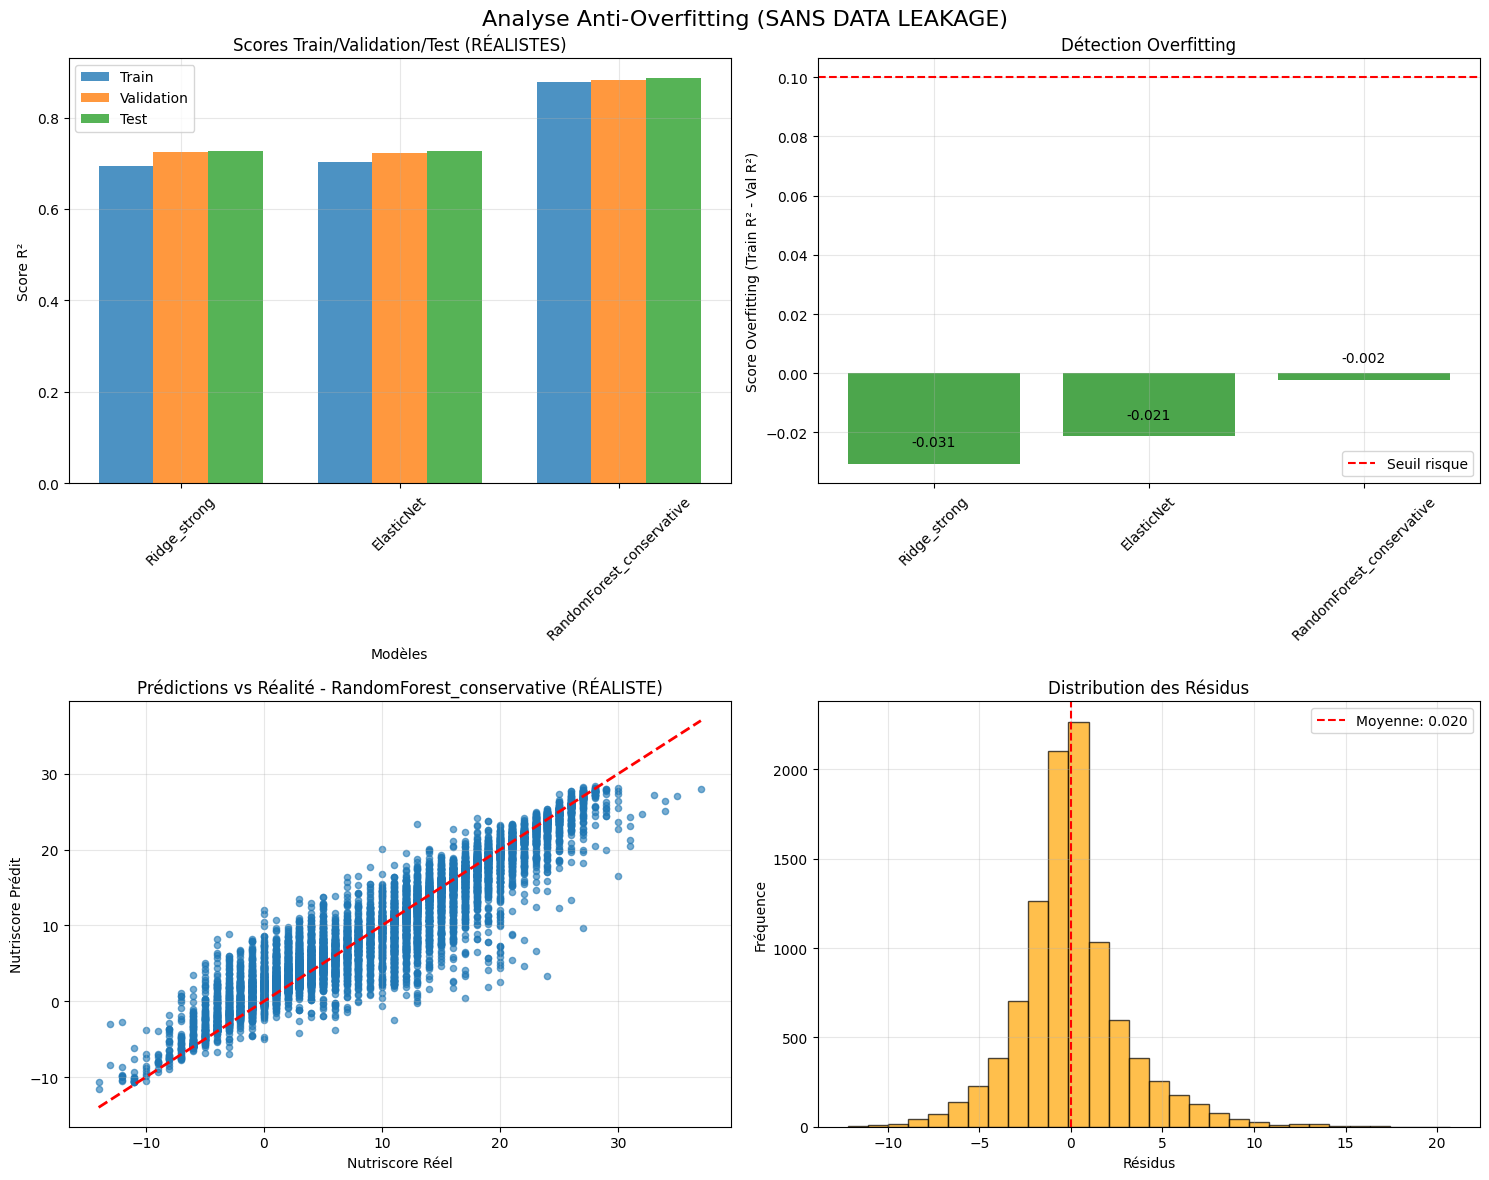


🏆 Sélection du modèle le plus robuste...
Ridge_strong:
   Test R²: 0.7276
   Overfitting: -0.0306
   Score généralisation: -4.2392
ElasticNet:
   Test R²: 0.7259
   Overfitting: -0.0214
   Score généralisation: -8.1750
RandomForest_conservative:
   Test R²: 0.8864
   Overfitting: -0.0022
   Score généralisation: 13.6072

🥇 Modèle le plus robuste: RandomForest_conservative
✅ Modèle RÉALISTE sauvegardé: nutriscore_models/realistic_model_20250703_085529.joblib

📋 RÉSUMÉ ANALYSE RÉALISTE
⏱️  Temps total: 297.91s
🏆 Meilleur modèle: RandomForest_conservative
📊 R² test: 0.8864
🛡️  Score overfitting: -0.0022
🎯 Features utilisées: 20
💾 Modèle sauvegardé: nutriscore_models/realistic_model_20250703_085529.joblib
✅ AUCUN DATA LEAKAGE DÉTECTÉ
🎉 EXCELLENT: Modèle très performant

✅ ANALYSE RÉALISTE TERMINÉE!
📁 Fichiers générés:
   - realistic_analysis.png
   - nutriscore_models/realistic_model_20250703_085529.joblib

🎯 MAINTENANT VOUS AVEZ UN MODÈLE VRAIMENT PRÉDICTIF!


In [4]:
if __name__ == "__main__":
    predictor, results = main_realistic()